# Predicting Customer Churn in a Telecommunications Company

**Problem Statemenet**

Customer churn is a significant issue in the telecommunications industry. Retaining existing customers is often more cost-effective than acquiring new ones. By analyzing customer data, we can identify patterns and factors that contribute to churn, enabling the company to take proactive measures to retain customers.

## 1. Import Libraries

In [56]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

## 2. Load Dataset

In [57]:
# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display first few rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**This dataset contains information about a telecom company’s customers, including:**

* Customer account information (customerID, tenure, contract type, payment method, monthly charges, total charges).
* Demographic information (gender, age range, senior citizen status, partner, dependents).
* Services subscribed (phone service, multiple lines, internet service, online security, online backup, device protection, tech support, streaming TV, streaming movies).
* The target variable is Churn, indicating whether the customer left within the last month.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3. Data Cleaning for EDA

3.1. Convert TotalCharges to Numeric

In [59]:
# Convert 'TotalCharges' to numeric, coerce errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check for missing values in 'TotalCharges'
missing_total_charges = df["TotalCharges"].isnull().sum()
print(f"Total missing values in 'TotalCharges': {missing_total_charges}")

Total missing values in 'TotalCharges': 11


3.2 Handle Missing Values

In [60]:
# Drop rows with missing 'TotalCharges'
df = df.dropna(subset=["TotalCharges"])

# Reset index
df.reset_index(drop=True, inplace=True)

3.3  Remove Unnecessary Columns

In [61]:
# Drop 'customerID' as it's not useful for prediction
df = df.drop(columns=["customerID"])

## 4. Exploratory Data Analysis (EDA)
### 4.1 Churn Distribution

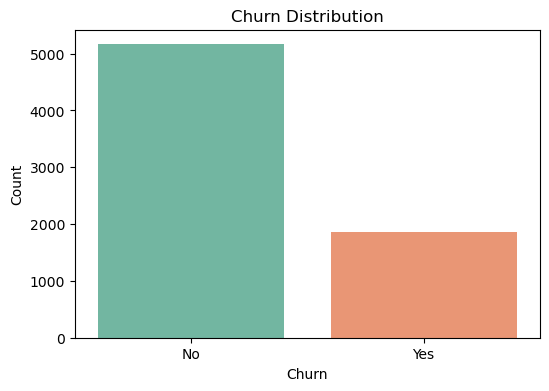

In [62]:
# Count plot for 'Churn'
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=df, palette="Set2")
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

The dataset is imbalanced with more ‘No’ churn instances than ‘Yes’.

### 4.2 Churn Rate by Contract Type

In [63]:
# Create 'Contract_Type' variable
df["Contract_Type"] = df["Contract"].apply(
    lambda x: "Short-term" if x == "Month-to-month" else "Long-term"
)
# Map 'Churn' to numeric for calculation
df["Churn_numeric"] = df["Churn"].map({"No": 0, "Yes": 1})

# Calculate churn rate
churn_rate = df.groupby("Contract_Type")["Churn_numeric"].mean().reset_index()
churn_rate["Churn_Rate (%)"] = churn_rate["Churn_numeric"] * 100
churn_rate = churn_rate.drop(columns=["Churn_numeric"])
churn_rate

,Contract_Type,Churn_Rate (%)
0,Long-term,6.778587
1,Short-term,42.709677


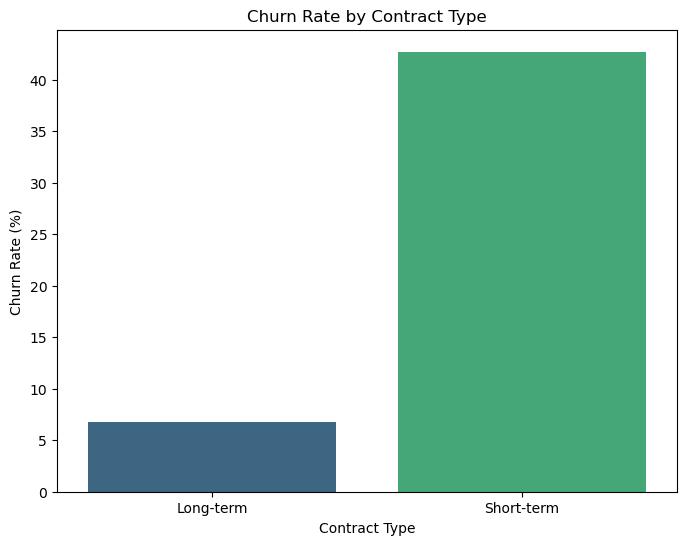

In [64]:
plt.figure(figsize=(8, 6))
sns.barplot(x="Contract_Type", y="Churn_Rate (%)", data=churn_rate, palette="viridis")
plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Churn Rate (%)")
plt.show()

Short-term contracts have a significantly higher churn rate compared to long-term contracts.

### 4.3 Tenure vs. Churn

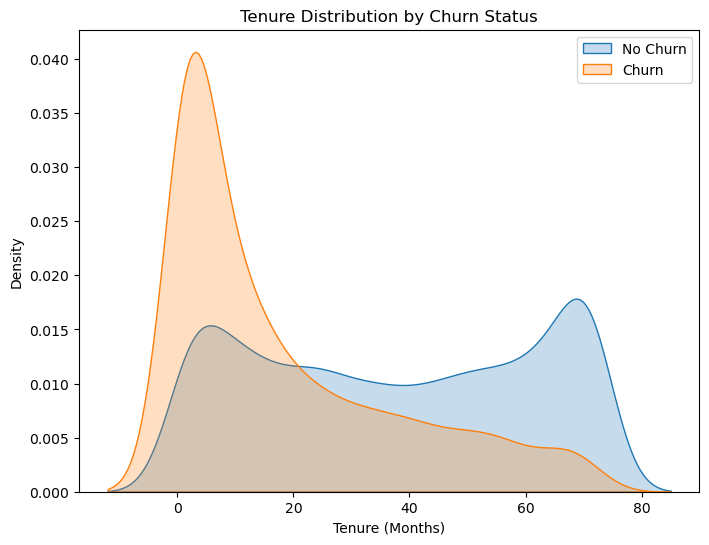

In [65]:
# Distribution plots for tenure
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df["Churn"] == "No"]["tenure"], label="No Churn", shade=True)
sns.kdeplot(df[df["Churn"] == "Yes"]["tenure"], label="Churn", shade=True)
plt.title("Tenure Distribution by Churn Status")
plt.xlabel("Tenure (Months)")
plt.ylabel("Density")
plt.legend()
plt.show()

Customers with shorter tenure are more likely to churn.

### 4.4 Monthly Charges vs. Churn

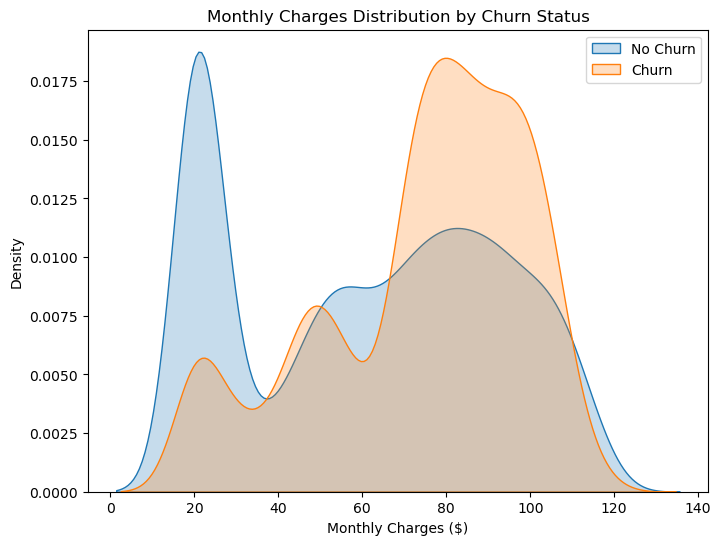

In [67]:
# Distribution plots for MonthlyCharges
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df["Churn"] == "No"]["MonthlyCharges"], label="No Churn", shade=True)
sns.kdeplot(df[df["Churn"] == "Yes"]["MonthlyCharges"], label="Churn", shade=True)
plt.title("Monthly Charges Distribution by Churn Status")
plt.xlabel("Monthly Charges ($)")
plt.ylabel("Density")
plt.legend()
plt.show()

Customers with higher monthly charges tend to churn more.

## 5. Data Preprocessing and Encoding

### 5.1 Encode Binary Variables

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [32]:
# List of binary variables to map
binary_features = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]

# Map 'Yes' to 1 and 'No' to 0
for col in binary_features:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [33]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Type,Churn_numeric
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,...,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,Short-term,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,...,No,No,One year,0,Mailed check,56.95,1889.50,0,Long-term,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,...,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,Short-term,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,...,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,Long-term,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,...,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,Short-term,1


In [34]:
# Map 'Short-term' to 0 and 'Long-term' to 1
df["Contract_Type"] = df["Contract_Type"].map({"Short-term": 0, "Long-term": 1})

### 5.2 One-Hot Encode Categorical Variables

In [35]:
# Identify categorical variables for one-hot encoding
categorical_vars = [
    "gender",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

In [36]:
# Drop 'Contract' variable since we have created Contract_Type, we can drop the original Contract variable to avoid multicollinearity.
df_encoded = df_encoded.drop(columns=["Contract_Two year", "Contract_One year"])

In [37]:
df_encoded=df_encoded.drop(columns=["Churn_numeric"],axis=1)

## 5.3 Handle Remaining Missing Values

In [38]:
df_encoded.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_Type,...,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,1,...,True,False,False,False,False,False,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,1,...,True,False,True,False,False,False,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,0,...,False,False,False,False,False,False,False,False,True,False


In [39]:
# Check for remaining missing values
df_encoded.isnull().sum()

SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
Contract_Type                            0
gender_Male                              0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV

## 5.4 Feature Scaling

In [40]:
# List of numerical features
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical features
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

## 6. Machine Learning Modeling
### 6.1 Define Features and Target

In [41]:
# Define target variable 'Churn'
y = df_encoded["Churn"]

# Define feature set 'X'
X = df_encoded.drop(columns=["Churn"])

### 6.2 Handling Class Imbalance

In [42]:
# Check class distribution
y.value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

the dataset is imbalanced. So applyng SMOTE to balance classes

In [43]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE to features and target
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
y_resampled.value_counts(normalize=True)

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

### 6.3 Split the Data

In [44]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

### 6.4 Feature Selection

Use Recursive Feature Elimination with Cross-Validation (RFECV)

In [45]:
# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Initialize RFECV
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring="accuracy")

# Fit RFECV
rfecv.fit(X_train, y_train)

# Optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected features:", list(selected_features))

Optimal number of features: 25
Selected features: ['Dependents', 'tenure', 'PhoneService', 'MonthlyCharges', 'TotalCharges', 'Contract_Type', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


### 6.5 Model Training and Evaluation
#### 6.5.1 Logistic Regression

In [46]:
# Create Logistic Regression model with selected features
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train[selected_features], y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test[selected_features])

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1033
           1       0.76      0.84      0.80      1033

    accuracy                           0.79      2066
   macro avg       0.79      0.79      0.79      2066
weighted avg       0.79      0.79      0.79      2066



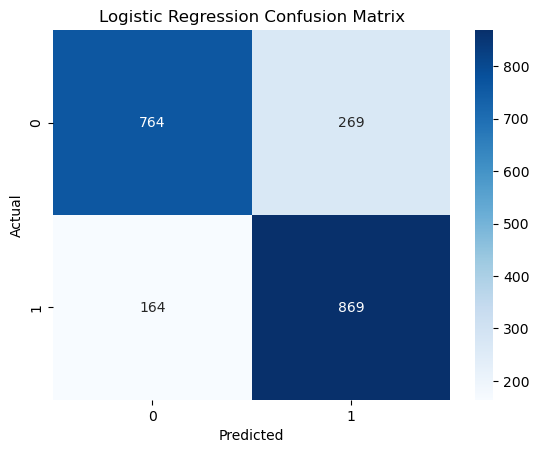

In [47]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

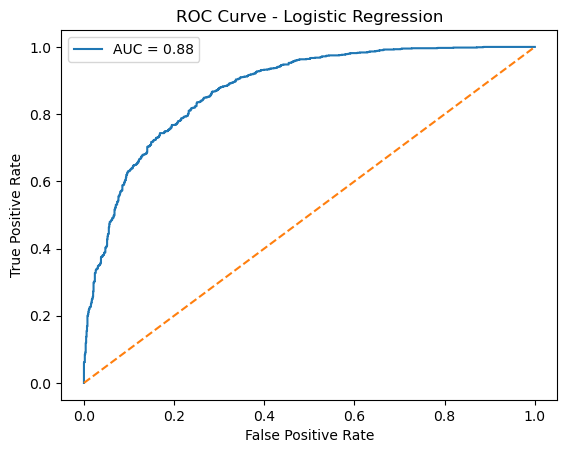

In [48]:
# ROC Curve
y_pred_proba = lr_model.predict_proba(X_test[selected_features])[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#### 6.5.2 Random Forest Classifier

In [49]:
# Define parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train[selected_features], y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [50]:
# Best Random Forest model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train[selected_features], y_train)

# Predict on test set
y_pred_rf = best_rf.predict(X_test[selected_features])

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1033
           1       0.80      0.86      0.83      1033

    accuracy                           0.82      2066
   macro avg       0.82      0.82      0.82      2066
weighted avg       0.82      0.82      0.82      2066



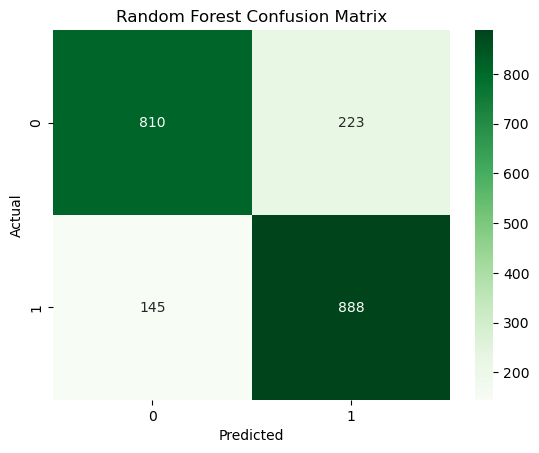

In [51]:
# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

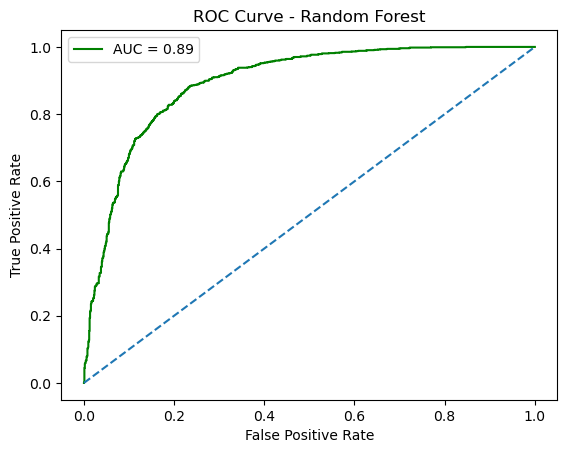

In [52]:
# ROC Curve
y_pred_proba_rf = best_rf.predict_proba(X_test[selected_features])[::, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_score_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_score_rf:.2f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

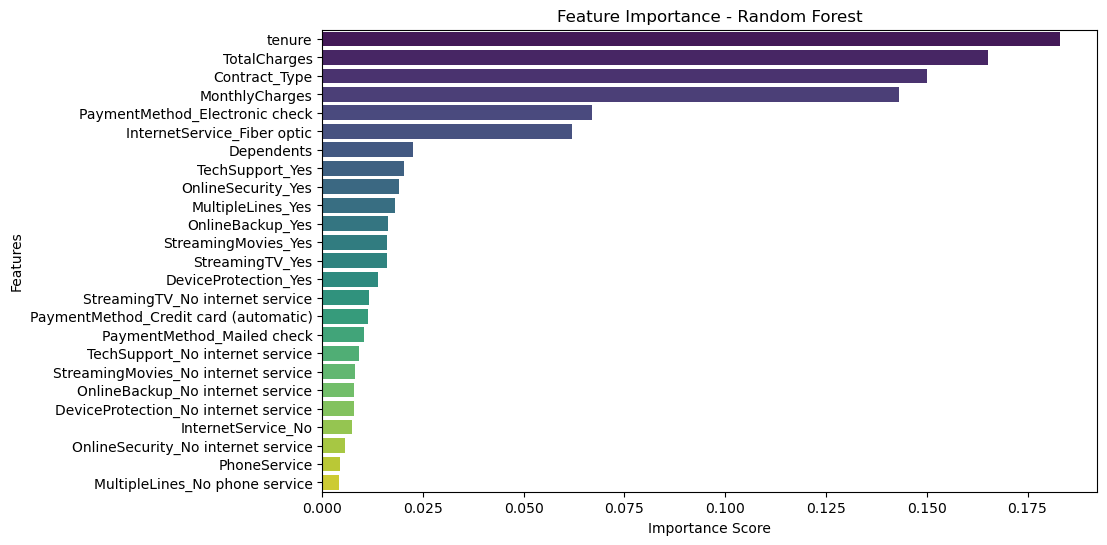

In [53]:
# Feature importance
importances = best_rf.feature_importances_
feature_importance = pd.Series(importances, index=selected_features).sort_values(
    ascending=False
)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

## 7. Conclusion

### Observation:
-  Model performance:
    - Logistic Regression:
        - Accuracy: 0.79
        - AUC: 0.88
    - Random Forest:
        - Accuracy: 0.82
        - AUC: 0.89
    - Both Logistic regression and Random Forest models perform well after handling class imbalance and feature selection.
	- Random Forest typically has higher accuracy and better ability to capture complex patterns.
- key predictors of Churn:
    - Tenure: Lower tenure increases the likelihood of churn.
	- Contract_Type: Short-term contracts are associated with higher churn.
	- MonthlyCharges: Higher charges are linked to increased churn.


### Recommendations:
- Customer Retention Strategies:
  - Tenure
    - Implement loyalty programs targeting new customers to increase tenure.
  - Contract
	- Encourage customers to switch to long-term contracts through incentives.
	- Provide discounts for customers who switch to longer-term contracts.
	- Create attractive packages that encourage customers to opt for longer contracts.
  - Monthly Chargers
	- Re-evaluate pricing models to ensure competitiveness.
	
  